Статистическое моделирование на ЭВМ  
Задание №1  
Работу выполнил Королев Е.В., студент М8О-401Б-18 группы  
Преподаватель: Мирошкин В.Л.  
Вариаент №6

Рассматривается модель измерения некоторого параметра $\theta$ со случайными ошибками:  
$$ y_m = \theta + \varepsilon_m, ~~ m=\overline{1,100} $$  
где $\{\varepsilon_m\}$ - центрированные независимые одинаково распределенные случайные величины.

Законы распределения ошибок:  
* $N(0,1)$;  
* $E(1,-1)$;  
* $0.9N(0,1) + 0.1N(0,100)$;  

Точное значение $\theta = -2$;  

Методом статистического моделирования найти с.к. -погрешности МНК-оценки $\hat\theta$ (выборочное среднее) и МНМ-оценки $\hat\theta$ (выборочная медиана) неизвестного параметра $\theta$ для различных вариантов распределения ошибок (смоделировать и обработать по 50 реа-лизаций каждой из оценок). Дать сравнительный анализ полученных оценок по их точности и чувствительности к виду закона распределения погрешностей.

In [2]:
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt

In [27]:
def plot_sample(gen_fun, n, bins=30):
    sample = [gen_fun() for _ in range(n)]
    plt.hist(sample, bins=bins, density=True)

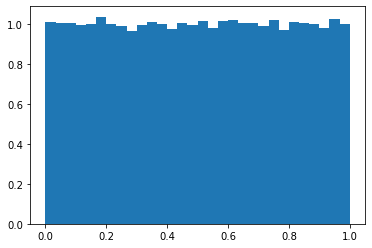

In [28]:
plot_sample(uniform, 100000)

In [13]:
# Box–Muller transform
def normal(mu=0, sigma=1):
    while True:
        u_1, u_2 = uniform(), uniform()
        v_1, v_2 = 2*u_1 - 1, 2*u_2 - 1
        s = v_1*v_1 + v_2*v_2
        if 0.0 < s < 1.0:
            break
    nu_1 = v_1 * np.sqrt(-2 * np.log(s) / s)
#     nu_2 = v_2 * np.sqrt(-2 * np.log(s) / s)
    return nu_1

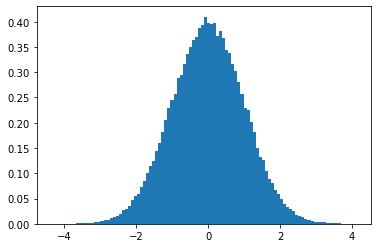

In [29]:
plot_sample(gen_fun=normal, n=100000, bins=100)

In [32]:
def normal_2(mu=0, sigma=1):
    rv = 0
    n = 40
    for i in range(n):
        rv += uniform()
    return rv - n/2

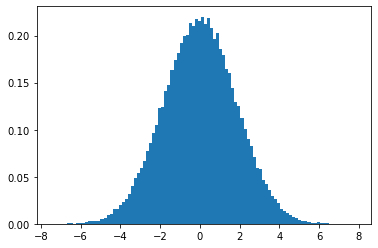

In [33]:
plot_sample(gen_fun=normal_2, n=100000, bins=100)

Выведем формулу для генерации СВ с экспоненциальным распределением.  
$E(\lambda, a): ~~ f(x)=\lambda e^{-\lambda(x-a)}, ~x > a$.  
Функция распределения вероятностей: $F(x) = \int\limits_0^x \lambda e^{-\lambda(s-a)}ds = -\int\limits_0^x e^{-\lambda(s-a)}d(-\lambda (s-a)) = 1 - e^{-\lambda(x-a)}$.  
Найдем обратную функцию к $F(X)$: $y = 1 - e^{-\lambda(x-a)} \leftrightarrow e^{-\lambda(x-a)} = 1 - y \leftrightarrow -\lambda(x-a) = \ln(1-y) \leftrightarrow x = a - \dfrac{\ln(1-y)}{\lambda}$.  
Если y имеет равномерное распределение от 0 до 1, то 1-y также имеет равномерное распределение от 0 до 1.  
Таким образом, получили формулу: $\xi = a - \dfrac{\ln(\mu)}{\lambda}$, позволяющую генерировать СВ с экспоненциальным распределением, используя генератор равномерного распределения.

In [37]:
def exponential(a=0, lam=1):
    return a - np.log(uniform())/lam

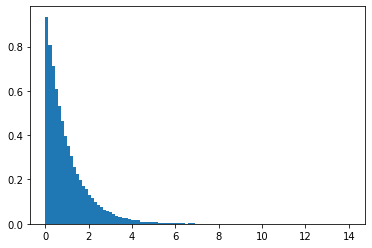

In [38]:
plot_sample(gen_fun=exponential, n=100000, bins=100)

Построим генератор для $0.9N(0,1) + 0.1N(0,100)$. Пусть с вероятностью $0.9$ из равномерного распределения генерируемая СВ принимает значение из $N(0,1)$, а в оставшихся случаях из $N(0,100)$. Таким образом данное распределение представляет собой распределение Тьюки, где с долей $\delta = 0.1$ происходят выбросы силой $\sigma_1^2 = 100\sigma_0^2$.

In [75]:
def tukey(delta=0.1, big_sigma=10):
    if delta > uniform():
        return delta * normal()
    else:
        return (1 - delta) * normal(sigma=big_sigma)

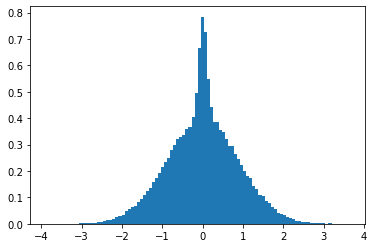

In [76]:
plot_sample(gen_fun=tukey, n=100000, bins=100)

In [77]:
# генерация выборок
def gen_samples(n=100):
    theta = -2
    y_1 = [theta + normal() for _ in range(n)]
    y_2 = [theta + normal_2() for _ in range(n)]
    y_3 = [theta + exponential() for _ in range(n)]
    y_4 = [theta + tukey() for _ in range(n)]
    
    return [y_1, y_2, y_3, y_4]

# МНК-оценка для тривиальной модели y = theta + eps
def MNK(y):
    return sum(y) / len(y)

# МНМ-оценка для тривиальной модели y = theta + eps
def MNM(y):
    n = len(y)
    y = sorted(y)
    if n % 2 == 0:
        return (y[n//2-1] + y[n//2]) / 2
    else:
        return y[n//2]

# генерация выборок и получение оценок для них
def get_estimations(n=100):
    y = gen_samples(n=n)
    thetas_mnk = [MNK(y_i) for y_i in y]
    thetas_mnm = [MNM(y_i) for y_i in y]
    print('normal,  normal_2,  exponential,  tukey')
    print('MNK:', thetas_mnk)
    print('MNM:', thetas_mnm)


# усреднение оценок, путем многократного
# проведения процесса генерации и оценивания
def get_mean_estimations(n=100, m=50):
    mean_mnk = [0, 0, 0, 0]
    mean_mnm = [0, 0, 0, 0]
    for i in range(m):
        y = gen_samples(n=n)
        for i in range(len(y)):
            mean_mnk[i] += MNK(y[i])
            mean_mnm[i] += MNM(y[i])
    mean_mnk = [mnk / m for mnk in mean_mnk]
    mean_mnm = [mnm / m for mnm in mean_mnm]
    print('normal,  normal_2,  exponential,  tukey')
    print('MNK:', mean_mnk)
    print('MNM:', mean_mnm)

In [71]:
get_estimations()
get_estimations(1000)
get_estimations(10000)
get_estimations(100000)

normal,  normal_2,  exponential,  tukey
MNK: [-1.9729532410064998, -1.8566761690554723, -0.9036876816044187, -2.1516811617990586]
MNM: [-2.0316332668898998, -1.6396263137327143, -1.2432184916382165, -2.042443834855991]
normal,  normal_2,  exponential,  tukey
MNK: [-2.0463369275815992, -2.0413943025559216, -0.9880739951024151, -1.985425136128931]
MNM: [-2.0782162136233175, -2.009601706230077, -1.3123748443434697, -1.9914354489777528]
normal,  normal_2,  exponential,  tukey
MNK: [-2.00398891168142, -2.0203292803443373, -0.9863462584177196, -2.0192863069084472]
MNM: [-2.0046913427581883, -2.0018231392955563, -1.3026046502425817, -2.010318526378438]
normal,  normal_2,  exponential,  tukey
MNK: [-2.0040278823929683, -1.998477145234694, -0.9974088169415017, -1.9976082906025447]
MNM: [-2.0052377447914993, -2.005542718915052, -1.3050661142182995, -1.9985527593123078]


In [74]:
get_mean_estimations()
get_mean_estimations(n=1000, m=1000)
get_mean_estimations(n=1000, m=10000)

normal,  normal_2,  exponential,  tukey
MNK: [-2.0146853998679743, -2.0239980598795366, -1.0091391307562951, -1.9935193807506886]
MNM: [-2.014921267072418, -2.0418760135380385, -1.3056591033494298, -2.010170092249017]
normal,  normal_2,  exponential,  tukey
MNK: [-1.9997253036925249, -2.000313956957532, -1.0000568293122902, -2.0005164810593605]
MNM: [-1.9998459452749715, -2.0009306047294984, -1.307009838798324, -2.0002081677174433]
normal,  normal_2,  exponential,  tukey
MNK: [-2.0003662300182006, -2.000322731515126, -0.9999633491698001, -1.9995975665479788]
MNM: [-2.000128927844819, -2.000938724630632, -1.3060461619906254, -1.9995721901295285]


Выводы: МНК-оценка оказалась наилучшей для случая ошибок с нормальным законом распределения, причем  
алгоритм Бокса - Мюллера оказаося лучше, чем алгоритм, основанный на центральной предельной теореме.  
В случае экпоненциальных ошибок ошибки имеют один и тот же знак, поэтому МНК и МНМ-оценки получаются  
смещенными, при этом МНК-оценка ровно в 2 раза меньше искомого параметра. Для данных с выбросами  
(распределение Тьюки) МНМ-оценка оказалась лучше, поскольку в ее основе лежит медианное среднее, а  
МНК-оценке среднее арифметическое. Для случая экспоненциальных ошибок можно попробовать квантильную  
регрессию с параметром квантиля, близким к 1.0.